# Predicting Carseats Sales with Decision Trees and Ensemble Methods
**Name:** Alan Lin

## Motivation
Retailers often want to understand what drives **product sales** and how to best predict them. In this project, I use the **Carseats dataset** from the ISLP package to predict Sales as a quantitative response.
I apply and compare **tree-based regression methods**:
- Decision Trees (with pruning)
- Bagging
- Random Forests

The goal is to evaluate predictive accuracy, interpretability, and feature importance across methods, building on concepts explored in ISLP.

## Data Analysis
### Importing Necessary Dependencies
We begin by importing important libraries and the dataset, which is loaded using the `ISLP` libraries. We then split the dataset into 70% training and 30% test observations. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RF 

# Load Carseats dataset
Carseats = load_data('Carseats')

# Create design matrix with all predictors except Sales
model = MS(Carseats.columns.drop('Sales'), intercept = False)
D = model.fit_transform(Carseats)

feature_names = list(D.columns)
X = np.asarray(D)

# Split dataset train (70%) and test (30%)
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Carseats['Sales'], test_size = 0.3, random_state = 0)

Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


The response variable is `Sales`, the unit sales (in thousands) at every location. The predictors are:
- `CompPrice`: Price charged by competitor at each location
- `Income`: Community income level (in thousands of dollars)
- `Advertising`: Local advertising budget for company at each location (in thousands of dollars)
- `Population`: Population size in region (in thousands)
- `Price`: Price company charges for car seats at each site
- `ShelveLoc`: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
- `Age`: Average age of the local population
- `Education`: Education level at each location
- `Urban`: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
- `US`: A factor with levels No and Yes to indicate whether the store is in the US or not

### Decision Tree Regressor
We begin with the simplest model, the decision tree. Decision trees provide an interpretable model for regression problems. However, unpruned trees often overfit, so we compare:  
1. A **full tree** (no pruning)  
2. A **pruned tree** chosen via cross-validation and cost-complexity pruning

In [2]:
# Create the Decision Tree Regressor model with a fixed random state for reproducibility
reg = DTR(random_state = 0)

# Fit the model to the training dataset
reg.fit(X_train , y_train)

# Predict values of test dataset
preds = reg.predict(X_test)

# Compute and print test MSE (error metric)
full_mse = np.mean((preds - y_test)**2)
print(f"Test MSE (full tree): {full_mse}")
print(f"Number of terminal nodes (full tree): {reg.get_n_leaves()}")

Test MSE (full tree): 5.083071666666667
Number of terminal nodes (full tree): 277


We now train a pruned tree by utilizing k-fold cross validation with $k = 5$ to see if the testing MSE will decrease.

In [3]:
# Cost-complexity pruning path
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)

# Cross-validation to select optimal alpha
kfold = skm.KFold(5, shuffle = True, random_state = 10)
grid = skm.GridSearchCV(
    reg, {'ccp_alpha': ccp_path.ccp_alphas}, 
    refit = True, cv = kfold, scoring='neg_mean_squared_error'
)

# Fit the model to the training dataset
G = grid.fit(X_train, y_train)
best_ = grid.best_estimator_

# Compute and print test MSE for pruned tree
cv_mse = np.mean((y_test - best_.predict(X_test))**2)
print(f"Test MSE (pruned tree): {cv_mse}")
print(f"Number of terminal nodes (pruned tree): {best_.get_n_leaves()}")

Test MSE (pruned tree): 4.431070971603666
Number of terminal nodes (pruned tree): 55


Despite dropping to 55 terminal nodes in the pruned tree as opposed to the 277 terminal nodes in the full tree, we improve the test MSE by over 10%, showcasing the power of pruned trees in capturing data patterns and delivering accurate predictions while reducing complexity by preventing overfitting.

### Bagging  

Bagging (Bootstrap Aggregating) reduces variance by training many trees on bootstrap samples and averaging their predictions. This typically improves predictive accuracy compared to a single tree by preventing overfitting and introducing randomization (through bootstrapping). We also examine **feature importance** to see which predictors matter most for Sales.

In [4]:
# Create the bagging model (random forest with all predictors considered)
bag_carseats = RF(max_features = X_train.shape[1], random_state = 0)

# Fit the model to the training dataset
bag_carseats.fit(X_train, y_train)

# Predict values of the test dataset
bag_preds = bag_carseats.predict(X_test)

# Compute and print test MSE
bag_mse = np.mean((bag_preds - y_test)**2)
print(f"Test MSE (bagging): {bag_mse}")

# Compute feature importance
importances = bag_carseats.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort feature importances in descending order and print
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importance for bagging model:")
print(feature_importance_df)

Test MSE (bagging): 2.0077445197500015
Feature importance for bagging model:
              Feature  Importance
4               Price    0.278666
5     ShelveLoc[Good]    0.222431
7                 Age    0.108637
0           CompPrice    0.097085
6   ShelveLoc[Medium]    0.082965
2         Advertising    0.074627
1              Income    0.051799
3          Population    0.040945
8           Education    0.030836
10            US[Yes]    0.006815
9          Urban[Yes]    0.005195


We see that bagging places the most emphasis on price and good shelf location. These are both logical indicators of sales performances, as the value of a good carseat and its selling position in a marketplace would heavily influence buyer traffic and encourage potential customers to consider and purchase the carseat.

### Random Forests
Random forests improve upon bagging by decorrelating trees. At each split, only a random subset of features is considered, which reduces the dominance of strong features and leads to more diverse trees. 

We evaluate random forests in two ways:  
1. **Varying $m$** (the number of features considered at each split) and plotting test MSE.  
2. Using the default recommendation of **$m = \sqrt{p}$** (rounded) and examining feature importance.

Our random forests will use 1,000 trees and vary in number of features considered.

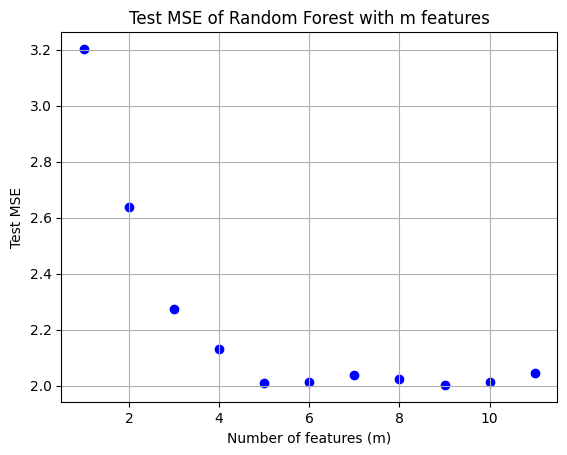

In [5]:
# Set up number of features
p = len(feature_names)

# Create lists for MSE values and number of features
rf_mse_vals = []
m_vals = np.arange(1, p+1)

# Fit a random forest for varying number of features
for i in m_vals:
    RF_carseats = RF(max_features = i, n_estimators = 1000, random_state = 0) # set random state for reproducibility
    RF_carseats.fit(X_train, y_train)
    rf_preds = RF_carseats.predict(X_test)
    rf_mse_vals.append(np.mean((rf_preds - y_test)**2))

# Plot MSE vs. m (number of features)
plt.scatter(m_vals, rf_mse_vals, color = "b")
plt.title("Test MSE of Random Forest with m features")
plt.xlabel("Number of features (m)")
plt.ylabel("Test MSE")
plt.grid()

**Figure 1:** Test mean squared error (MSE) of random forests with varying numbers of features.

The test MSE decreases sharply when $m$ increases from very small values, but then stabilizes. This is expected: once the strongest predictors are available to the trees, adding more predictors only increases correlation between trees without reducing bias much further. As a result, the predictive accuracy levels off, with small fluctuations due to randomness.

We now move on to the default procedure of setting $m = \sqrt{p}$ to see the MSE metric and feature importances.  

In [6]:
# Print number of features and m = sqrt(p) value
print("Number of features (p):", p)
m = round(np.sqrt(p))
print("m = sqrt(p):", m)

# Create random forest with m = sqrt(p) features and random state for reproducibility
RF_carseats_opt = RF(max_features = m, n_estimators = 1000, random_state = 0)

# Fit the model to the training dataset
RF_carseats_opt.fit(X_train, y_train)

# Predict values of the test dataset
rf_preds_opt = RF_carseats_opt.predict(X_test)

# Compute and print test MSE
rf_opt_mse = np.mean((rf_preds_opt - y_test)**2)
print(f"Test MSE (random forest with sqrt(p) features): {rf_opt_mse}")

# Compute feature importance
importances = RF_carseats_opt.feature_importances_
feature_importance_df = pd.DataFrame({
     'Feature': feature_names,
     'Importance': importances
})

# Sort feature importances in descending order and print
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature importance for model with m = sqrt(p) features:")
print(feature_importance_df)

Number of features (p): 11
m = sqrt(p): 3
Test MSE (random forest with sqrt(p) features): 2.2756299329358276
Feature importance for model with m = sqrt(p) features:
              Feature  Importance
4               Price    0.243342
5     ShelveLoc[Good]    0.160471
7                 Age    0.122006
0           CompPrice    0.097027
2         Advertising    0.087855
1              Income    0.085006
3          Population    0.076153
8           Education    0.050686
6   ShelveLoc[Medium]    0.048134
10            US[Yes]    0.016977
9          Urban[Yes]    0.012344


The rule-of-thumb $m = \sqrt{p}$ is a reasonable default, but it does not always minimize test error. In this dataset, the optimal $m$ could be slightly higher or lower depending on which features are most predictive and how correlated they are, reflecting the practical challenges of balancing bias and variance in real-world machine learning.

### Overall Takeaways
**Decision Trees:**
- Easy to interpret and visualize.
- Full trees tend to overfit, leading to higher test MSE.
- Pruning improves generalization by reducing the number of terminal nodes, balancing bias and variance.

**Bagging:**
- Aggregating multiple trees reduces variance and stabilizes predictions.
- Test MSE is lower than a single decision tree, showing the benefit of ensemble averaging.
- Feature importance analysis highlights the predictors most strongly influencing Sales, providing actionable insights.

**Random Forests:**
- Further reduces variance by decorrelating trees through random feature selection at splits.
- Provides the best predictive performance in this dataset.
- The choice of $m$ (number of features per split) affects performance, and the default heuristic $m = \sqrt{p}$ is reasonable but not guaranteed optimal.

**Practical insights:**
- Certain predictors (e.g., Price, ShelveLoc, Age) consistently emerge as important, reflecting key drivers of product sales.
- Ensemble methods balance interpretability and accuracy, making them useful for both predictive modeling and business decision-making.

**Overall learning:**
- Tree-based methods offer flexible modeling for tabular data.
- Combining multiple trees via bagging or random forests improves predictive reliability.
- Understanding hyperparameters, like pruning complexity or m in random forests, is critical to achieving strong generalization.